# 자동차 연비 예측하기: 회귀
참고) https://www.tensorflow.org/tutorials/keras/regression

regression은 가격이나 확률 같이 연속된 출력 값을 에측하는 것이 목적이다.  
'Auto MPG' data set을 사용하여 1970년대 후반과 1980년 초반의 자동차 연비를 예측하는 모델을 만든다.  
이 정보에는 실린더 수, 배기량, 마력, 공차 중량 같은 속성이 포함된다.

In [1]:
pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.0


### Auto MPG Data set
#### - Data Download

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

40960/30286 [========================================] - 0s 1us/step


'/aiffel/.keras/datasets/auto-mpg.data'

#### - Read data with Pandas

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### - Refine data
누락된 데이터가 있다. 일단 체크하기

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

확인된 결측치의 행을 삭제한다.

In [6]:
dataset = dataset.dropna()

"Origin"열은 수치형이 아니고 범주형이므로 원핫인코딩으로 변환한다.

In [7]:
origin = dataset.pop('Origin')

In [8]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## Separate Train data, Test data

In [9]:
train_dataset = dataset.sample(frac = 0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Exploration data
훈련 세트에서 몇 개의 열을 선택해 산점도 행렬 만들어 보기

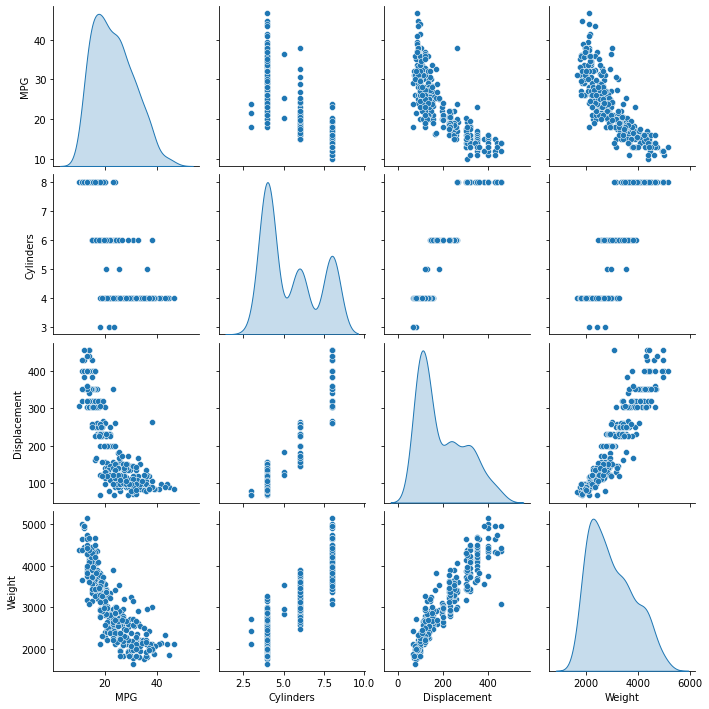

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

- 전반적인 통계 확인하기

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


- 특성과 레이블 분리하기

In [12]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

- 데이터 정규화  
특성의 스케일과 범위가 다르면 정규화하는 것이 좋다.

In [13]:
def norm(x):
    return (x - train_stats['mean'])/train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

정규화되었으니 모델을 훈련한다.

## 모델
#### - 모델 만들기
(두 개의 완전 연결 은닉층으로 Sequential 모델을 만든다.)

In [14]:
def build_model():
      model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
      ])

      optimizer = tf.keras.optimizers.RMSprop(0.001)
    
      model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
      return model

In [15]:
model = build_model()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


#### - 모델 실행해보기
(10샘플의 하나의 배치로 만들어 사용한다.)

In [18]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.3505265 ],
       [ 0.31831846],
       [ 0.20280358],
       [ 0.6833719 ],
       [ 0.5957726 ],
       [ 0.06331219],
       [ 0.59088266],
       [ 0.46760696],
       [-0.04709988],
       [ 0.67506814]], dtype=float32)

## - Training model

In [19]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

history객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] =  history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3.407512,1.197891,3.407512,9.626891,2.376773,9.626891,995
996,2.892997,1.101693,2.892997,9.237428,2.327374,9.237428,996
997,3.127998,1.172101,3.127998,9.918777,2.334085,9.918777,997
998,3.060651,1.155104,3.060651,9.281528,2.310964,9.281528,998
999,3.235713,1.174790,3.235713,9.196112,2.290918,9.196112,999


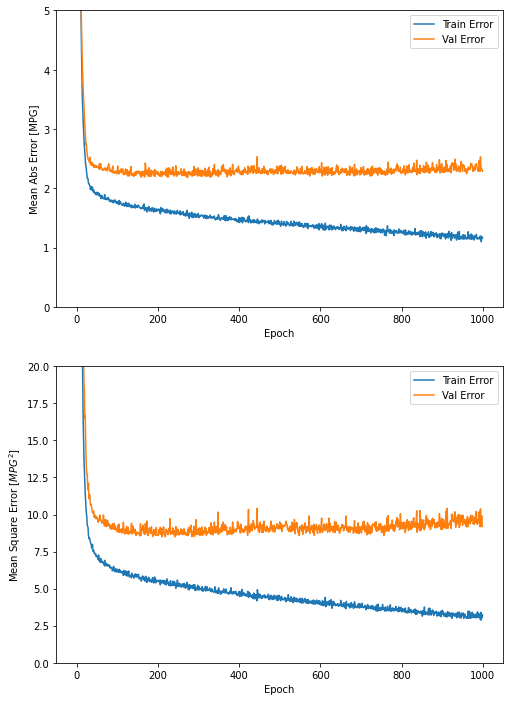

In [21]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

#### - 그래프 해석
수 백번 에폭을 진행한 이후에는 모델이 거의 향상되지 않아 보인다. 적당한 수준에서 끊기 위해 ealry stopping을 쓴다.


...................................................................

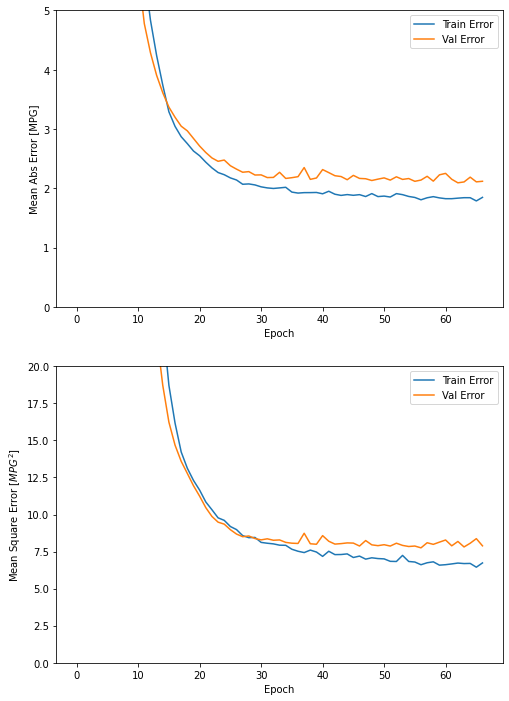

In [23]:
model = build_model()

#patience 매개변수는 성능 향상을 체크할 에폭 수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs =EPOCHS,
                   validation_split=0.2, verbose =0, callbacks=[early_stop, PrintDot()])

plot_history(history)

validation set의 평균 오차가 약 +/-2 MPG이다.

이제 test dataset으로 모델 성능을 확인한다.

In [24]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("test set MAE(평균 절대 오차): {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.3608 - mae: 1.8284 - mse: 5.3608
test set MAE(평균 절대 오차):  1.83 MPG


## Predict
test dataset을 사용해 MPG값을 예측한다.

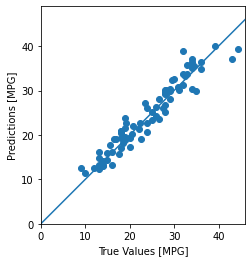

In [25]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

모델이 예측을 잘하고 있다.

오차의 분포를 보자.

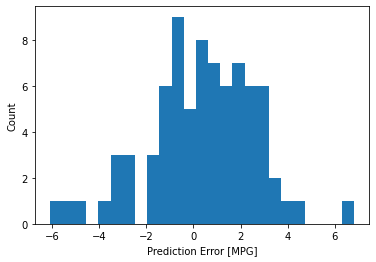

In [26]:
error = test_predictions - test_labels
plt.hist(error, bins =25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## Conclusion
- MSE는 회귀 문제에서 자주 사용하는 loss function이다.
- MAE는 평균 절댓갑 오차이다.(회귀 지표로 씀)
- 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 한다.
- 훈련 데이터가 많지 않다면 overfitting을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 것이 좋다.
- early stopping은 오버티핑을 막기 위한 방법이다.